### 사용할 패키지 불러오기

In [5]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, SimpleRNN
from statsmodels.tsa.arima_process import arma_generate_sample
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Epochs 전에 학습을 한 경우, 미리 멈출 수 있음
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
#val_loss가 최소일때, 스탑 이때, 찾더라도 20회 기다려라

## 1. MLP 모델

## 데이터 생성

In [12]:
np.random.seed(12313)
#time series: 데이터를 수집할때, 동일한 간격, 동일한 주기로 뽑아내야한다. 


In [13]:
# [0, 1, 2, 3] , window_size = 2      =>   [ [0, 1], [1, 2], [2, 3] ]
def create_dataset(signal_data, window_size=1): #window_size =1은 default값
    dataX, dataY = [], []
    for i in range(len(signal_data)-window_size):
        dataX.append(signal_data[i:(i+window_size)])
        dataY.append(signal_data[i + window_size])
    return np.array(dataX), np.array(dataY)

In [18]:
# arima 파라미터 설정
arparams = np.array([.75, -.25])
print(arparams)
maparams = np.array([.65, .35])
ar = np.r_[1, -arparams] # add zero-lag and negate
print(ar)

# np.r_이란?
# 두 배열을 왼쪽에서 오른쪽으로 붙이기 
# np.r_[a, b] = [a] +[b]

ma = np.r_[1, maparams] # add zero-lag
print(ma)


#AR: 자기회귀(Autoregression). 이전 관측값의 오차항이 이후 관측값에 영향을 주는 모형이다.(이전의 관측값의 영향-단일값)
#AR = > windowsize: 입력값  *실험결과 windowsize가 어느 정도 크기 내에서 클수록 예측력이 좋음
# =>자기 상관성 
#MA: 이동평균(Moving Average). 관측값이 이전의 연속적인 오차항의 영향을 받는다는 모형이다.  (이전의 연속적인 오차하의 영향-추세)

[ 0.75 -0.25]
[ 1.   -0.75  0.25]
[1.   0.65 0.35]


In [49]:
signal_data = arma_generate_sample(ar, ma, 10000)   

# arima 데이터 생성
# arma_generate_sample(ar=ar, ma=ma, nsample=n)
print(len(signal_data)) # => 10,000개 생성

signal_data = signal_data[8900: ] # 앞에 값을 조금 자름 
print(len(signal_data))

10000
1100


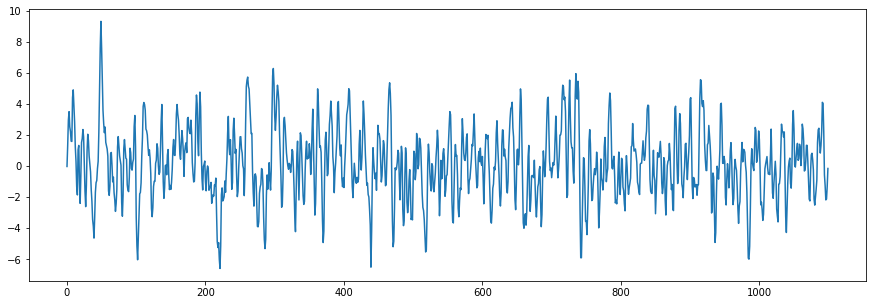

In [50]:
plt.figure(figsize=(15, 5))
plt.plot(signal_data)
plt.show()

## 데이터 전처리

In [51]:
# MinMaxScalar
maxValue = np.max(signal_data)
minValue = np.min(signal_data)
signal_data = (signal_data - minValue) / (maxValue - minValue)
# 모든 데이터는 normalization 추천(why? 학습시에 발산하는 것을 방지 할 수 있다.)

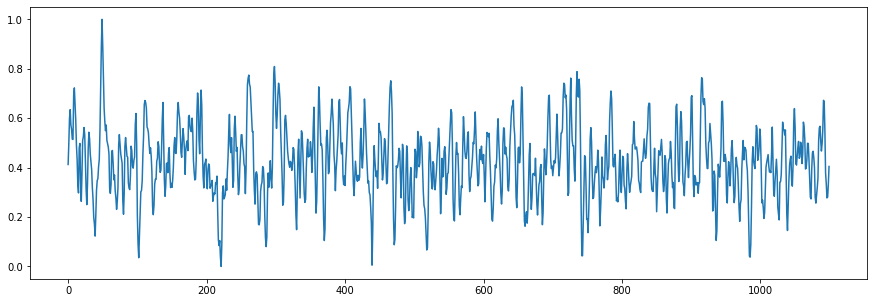

In [52]:
plt.figure(figsize=(15, 5))
# plt.plot(signal_data[0:300])
plt.plot(signal_data)
plt.show()

In [63]:
# 데이터 분리
train = signal_data[0:800]
val = signal_data[800:900]
test = signal_data[900:]

In [64]:
window_size = 9
print(len(signal_data)-window_size)

#window_size가 왜 9일까. 9개와 그다음 10번째를 매핑할때, 잘 맞는지 체크할 것이다.
# (시행착오, 경헝적인 방법으로 입력값을 조절할 수 밖에 없음)
# 따라서, create_dataset에서 for 문이 작동하는 횟수가 len(signal_data)-window_size이다. 
# 왜냐하면, 맨뒤의 9개는 예측을 위한 input값이 없어진다.  

# 데이터셋 생성
x_train, y_train = create_dataset(train, window_size)
x_val, y_val = create_dataset(val, window_size)
x_test, y_test = create_dataset(test, window_size)
# -> 출력:yt / 입력: yt-1, yt-2 ... ... 
print(y_train[0 : 5])
print(len(signal_data))

1091
[0.72266421 0.65740946 0.59227402 0.49112263 0.43366065]
1100


## MLP 모델 구성 및 생성

In [65]:
model1 = Sequential()
model1.add(Dense(32, input_dim = window_size, activation = 'relu'))
model1.add(Dense(16, activation = 'relu'))
model1.add(Dense(8, activation = 'relu'))


# layer가 많을 수록 값에 대한 손실이 크고 backpropagation에서 최초 layer에 도달할 확률이 떨어진다.
# => Relu함수는 sigmoid 함수보다 gradient search(미분방향 최적화)에서 손실이 작다.
# ReLU 함수는 그림에 있는 것처럼 0보다 작을 때는 0을 사용하고, 0보다 큰 값에 대해서는 해당 값을 그대로 사용하는 방법이다. 
# 음수에 대해서는 값이 바뀌지만, 양수에 대해서는 값을 바꾸지 않는다.
model1.add(Dense(4, activation = 'relu'))
model1.add(Dense(1))
# 해당 예측 모델(prediction model)에서 출려값은 1개이다. 9개의 데이터(n ~n+9)를 가지고 다음 10번째 데이터(n+10)를 예측한다.

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                320       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
_________________________________________________________________


In [66]:
model1.compile(optimizer = 'adam', loss = 'mean_squared_error') 
#Adam(lr=0.001)로 설정하여, 학습률을 조절할 수 있다./Adam

In [67]:
hist = model1.fit(x_train, y_train, epochs = 500, 
                  batch_size = 16, shuffle = False, callbacks=[es], validation_data = (x_val, y_val))
# hist = model1.fit(x_train, y_train, epochs = 500, 
#                   batch_size = 16, validation_data=(x_val, y_val), 
#                   shuffle = False, callbacks=[es])
# 시계열 문제는 deterministic 한 수학적 모델이 아니다. 내제된 많은 오류값이 있을 수 있다. 따라서, 관계성이 명확하게 나올 수 없다.

Train on 791 samples, validate on 91 samples
Epoch 1/500
791/791 [==============================] - 0s 188us/step - loss: 0.0827 - val_loss: 0.0097
Epoch 2/500
791/791 [==============================] - 0s 63us/step - loss: 0.0143 - val_loss: 0.0075
Epoch 3/500
791/791 [==============================] - 0s 61us/step - loss: 0.0105 - val_loss: 0.0069
Epoch 4/500
791/791 [==============================] - 0s 61us/step - loss: 0.0089 - val_loss: 0.0069
Epoch 5/500
791/791 [==============================] - 0s 62us/step - loss: 0.0081 - val_loss: 0.0066
Epoch 6/500
791/791 [==============================] - 0s 59us/step - loss: 0.0076 - val_loss: 0.0062
Epoch 7/500
791/791 [==============================] - 0s 60us/step - loss: 0.0072 - val_loss: 0.0060
Epoch 8/500
791/791 [==============================] - 0s 62us/step - loss: 0.0069 - val_loss: 0.0056
Epoch 9/500
791/791 [==============================] - 0s 59us/step - loss: 0.0067 - val_loss: 0.0054
Epoch 10/500
791/791 [==============

## MLP 모델 평가

In [68]:
# 6. 모델 평가하기
trainScore = model1.evaluate(x_train, y_train, batch_size=16, verbose=0)
print('Train Score: ', trainScore)

testScore = model1.evaluate(x_test, y_test, batch_size=16, verbose=0)
print('Test Score: ', testScore)

# verbose는 console에 출력하는 형태를 결정한다. verbose= 1,2,3~ 옵션 선택 가능
# Train score는 훈련 데이터 셋의 정확도/ Test score은 테스트 셋의 정확도 =>유사했을때, 이상적이고 test가 크면 과대적합

Train Score:  0.0040105367515014785
Test Score:  0.0038335013827455293


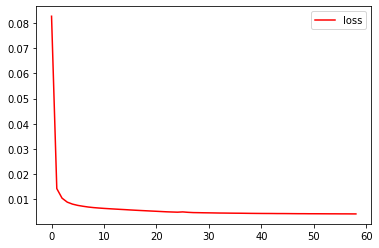

In [69]:
plt.plot(hist.history['loss'], c = 'r', label = 'loss')
plt.legend(loc = 'best')
plt.show()


In [71]:
# 모델 평가
model1_pred = model1.predict(x_test, batch_size = 16)
# fitting에서 batch_size는 데이터를 예측할때, 16개에 한번씩 평가를 하고 가중치를 개선한다.
# predict에서는 예측할 데이터 묶음을 몇 번에 한 번씩 할 것인지 결정한다. 

print(model1_pred[0:10])
print(model1_pred)

[[0.393901  ]
 [0.3729468 ]
 [0.30029434]
 [0.39275345]
 [0.3668484 ]
 [0.61700624]
 [0.7338279 ]
 [0.7244913 ]
 [0.7150833 ]
 [0.58285487]]
[[0.393901  ]
 [0.3729468 ]
 [0.30029434]
 [0.39275345]
 [0.3668484 ]
 [0.61700624]
 [0.7338279 ]
 [0.7244913 ]
 [0.7150833 ]
 [0.58285487]
 [0.6244991 ]
 [0.6395009 ]
 [0.5597609 ]
 [0.4126738 ]
 [0.44000733]
 [0.41490567]
 [0.41315687]
 [0.5647041 ]
 [0.48353294]
 [0.5965891 ]
 [0.49152523]
 [0.45386264]
 [0.41725063]
 [0.12881015]
 [0.3485134 ]
 [0.50799066]
 [0.3401761 ]
 [0.19492367]
 [0.13425033]
 [0.3010063 ]
 [0.41160196]
 [0.44626534]
 [0.35516942]
 [0.387878  ]
 [0.46952415]
 [0.49726275]
 [0.7386937 ]
 [0.6191982 ]
 [0.5073647 ]
 [0.36813235]
 [0.4497579 ]
 [0.48018548]
 [0.4043803 ]
 [0.25275788]
 [0.31883568]
 [0.47642338]
 [0.43903542]
 [0.37159294]
 [0.326231  ]
 [0.45870546]
 [0.5181554 ]
 [0.48558575]
 [0.40180105]
 [0.2993206 ]
 [0.29392442]
 [0.35124478]
 [0.47940457]
 [0.44789752]
 [0.39568886]
 [0.41639993]
 [0.3144942 ]
 [0.2

In [74]:
# 모델 평가
model1_pred = model1.predict(x_test, batch_size = 16)
print(model1_pred[0:10])

[[0.393901  ]
 [0.3729468 ]
 [0.30029434]
 [0.39275345]
 [0.3668484 ]
 [0.61700624]
 [0.7338279 ]
 [0.7244913 ]
 [0.7150833 ]
 [0.58285487]]


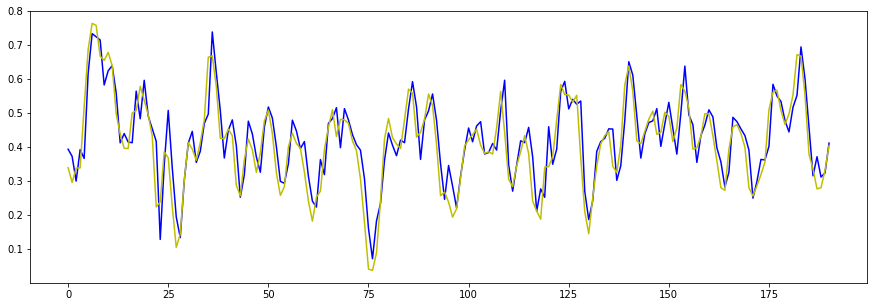

In [75]:
plt.figure(figsize = (15, 5))
plt.plot(model1_pred, 'b')
plt.plot(y_test, 'y')
plt.show()

# 2. LSTM 모델

## 데이터셋 생성 및 전처리

In [89]:
'''
LSTM(Long Short Term Model)은 RNN의 확장 버전이다.
기존의 RNN 모데일이 이전 값의 영향을 많이 받는 특징을 가지고 있어 오래된 값을 보존하는데 어려움이 있다.
LSTM은 따로 cell gate를 만들어, 기존의 변수를 보존하고 가중치가 매겨진 변수에 영향을 주는 식으로 작동한다.
=> 순차적인 데이터에서 과거의 값들이 영향을 줄 수 있다. 
'''



# window_size = 10
# 데이터셋 생성
x_train, y_train = create_dataset(train, window_size)
x_test, y_test = create_dataset(test, window_size)

print(x_train.shape)


(791, 9)


In [92]:
# 데이터셋 전처리
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
print(x_train.shape)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)


(791, 9, 1)
[[[0.41263761]
  [0.49746111]
  [0.60048754]
  ...
  [0.51511642]
  [0.51392479]
  [0.69155361]]

 [[0.49746111]
  [0.60048754]
  [0.63454345]
  ...
  [0.51392479]
  [0.69155361]
  [0.72266421]]

 [[0.60048754]
  [0.63454345]
  [0.57268239]
  ...
  [0.69155361]
  [0.72266421]
  [0.65740946]]

 ...

 [[0.40284799]
  [0.4360285 ]
  [0.45390044]
  ...
  [0.26130615]
  [0.30004272]
  [0.40354727]]

 [[0.4360285 ]
  [0.45390044]
  [0.37343644]
  ...
  [0.30004272]
  [0.40354727]
  [0.47101418]]

 [[0.45390044]
  [0.37343644]
  [0.26515458]
  ...
  [0.40354727]
  [0.47101418]
  [0.33557819]]]


## 손실 이력 저장 클래스

In [93]:
class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))


## LSTM 모델 생성

In [94]:
history = CustomHistory() # 손실 이력 객체 생성
history.init()
def fit_lstm(x_train, y_train, x_val, batch_size, nb_epoch, neurons):
  import time
  from time import strftime
  start_time = time.time()
  
  
  
  model = Sequential()
  
#   LSTM(output_dim, input_shape = ((window_size, input_dim)), stateful=True) [LSTM 상태유지 스택 쌓기]
#   for i in range(3):
#       model.add(LSTM(16, batch_input_shape=(batch_size, x_train.shape[1], x_train.shape[2]), stateful=True, return_sequences=True))
#   model.add(LSTM(neurons, stateful=True, batch_input_shape=(batch_size, x_train.shape[1], x_train.shape[2]), return_sequences = False))

  model.add(LSTM(neurons, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences = False))
  model.add(Dense(1))
# input shape=(input_length 윈도우 사이즈 크기,input_Dimension 속성을 여러개 둘 수 있음)
# return_sequences는 default파라미터 / stateful이 true이면, cellgate가 다음 cell에 영향을 준다 

# 즉,MLP는 속성input_Dimension만 볼수 있지만, LSTM은 input_Dimension과 윈도우 사이즈 크기를 고려할 수 있다.
  print(model.summary())
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(x_train, y_train, epochs=nb_epoch, batch_size=batch_size, verbose=1, shuffle=False, callbacks=[history, es], validation_data = (x_val, y_val))
  
#   for i in range(nb_epoch): [상태유지 사용할 때 model의 상태를 reset하기 위해 사용]
#       temp_time = time.time()
#       model.fit(x_train, y_train, epochs=1, batch_size=batch_size, verbose=0, shuffle=False, callbacks=[history])
#       model.reset_states()
#       print(str(i + 1) + ' epoch \n걸린 시간(second) : ', time.time() - temp_time)

  print('\n걸린 시간(second) : ', time.time() - start_time)
  return model

In [95]:
# 5. 모델 학습시키기
num_epochs = 500

model2 = fit_lstm(x_train, y_train, x_val, 16, num_epochs, 8)
#output dimentsion은 16개

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
None
Train on 791 samples, validate on 91 samples
Epoch 1/500
791/791 [==============================] - 0s 533us/step - loss: 0.1314 - val_loss: 0.0424
Epoch 2/500
791/791 [==============================] - 0s 177us/step - loss: 0.0276 - val_loss: 0.0107
Epoch 3/500
791/791 [==============================] - 0s 179us/step - loss: 0.0193 - val_loss: 0.0107
Epoch 4/500
791/791 [==============================] - 0s 173us/step - loss: 0.0191 - val_loss: 0.0105
Epoch 5/500
791/791 [==============================] - 0

791/791 [==============================] - 0s 204us/step - loss: 0.0050 - val_loss: 0.0040
Epoch 74/500
791/791 [==============================] - 0s 208us/step - loss: 0.0049 - val_loss: 0.0040
Epoch 75/500
791/791 [==============================] - 0s 204us/step - loss: 0.0049 - val_loss: 0.0040
Epoch 76/500
791/791 [==============================] - 0s 201us/step - loss: 0.0049 - val_loss: 0.0040
Epoch 77/500
791/791 [==============================] - 0s 209us/step - loss: 0.0048 - val_loss: 0.0039
Epoch 78/500
791/791 [==============================] - 0s 202us/step - loss: 0.0048 - val_loss: 0.0039
Epoch 79/500
791/791 [==============================] - 0s 195us/step - loss: 0.0048 - val_loss: 0.0039
Epoch 80/500
791/791 [==============================] - 0s 199us/step - loss: 0.0047 - val_loss: 0.0039
Epoch 81/500
791/791 [==============================] - 0s 202us/step - loss: 0.0047 - val_loss: 0.0039
Epoch 82/500
791/791 [==============================] - 0s 202us/step - loss:

## LSTM 모델 평가

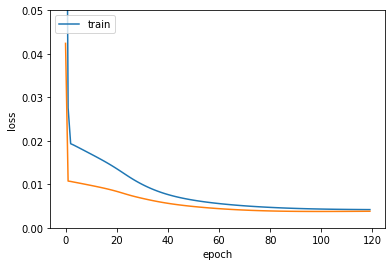

In [96]:
# 5. 학습과정 살펴보기
plt.plot(history.train_loss)
plt.plot(history.val_loss)

plt.ylim(0.0, 0.05)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [26]:
# 6. 모델 평가
trainScore = model2.evaluate(x_train, y_train, batch_size=1, verbose=0)
model2.reset_states()
print('Train Score: ', trainScore)

testScore = model2.evaluate(x_test, y_test, batch_size=1, verbose=0)
model2.reset_states()
print('Test Score: ', testScore)


Train Score:  0.004726829473575636
Test Score:  0.004794982104631321


In [27]:
# 7. 모델 사용 -- 바로 다음 값 예측
model2_pred = model2.predict(x_test, batch_size = 1)
model2.reset_states()


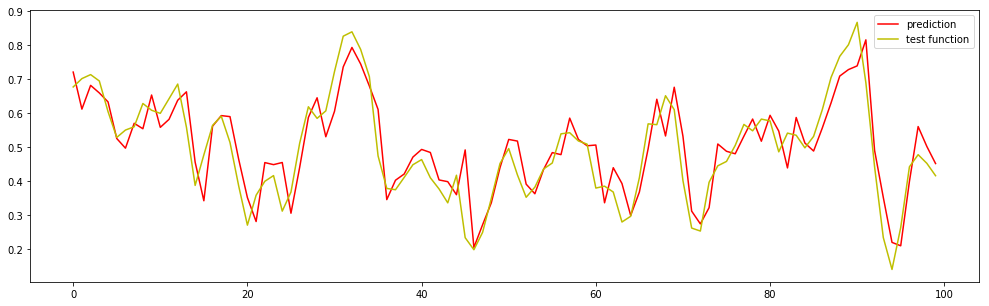

In [28]:
plt.figure(figsize=(17,5))
plt.plot(model2_pred[0 : 100],'r',label="prediction")
plt.plot(y_test[0 : 100], 'y', label="test function")
plt.legend()
plt.show()

## RNN 모델

In [0]:
model3 = Sequential()
model3.add(SimpleRNN(8, input_shape = (x_train.shape[1], x_train.shape[2])))
model3.add(Dense(1))

In [0]:
model3.compile(loss='mse', optimizer = 'adam')

In [98]:
history = model3.fit(x_train, y_train, epochs=500, shuffle = False, callbacks = [es],  validation_data = (x_val, y_val))

Train on 798 samples, validate on 98 samples
Epoch 1/500
798/798 [==============================] - 2s 2ms/step - loss: 0.6258 - val_loss: 0.3596
Epoch 2/500
798/798 [==============================] - 0s 61us/step - loss: 0.2280 - val_loss: 0.1218
Epoch 3/500
798/798 [==============================] - 0s 63us/step - loss: 0.0750 - val_loss: 0.0493
Epoch 4/500
798/798 [==============================] - 0s 61us/step - loss: 0.0352 - val_loss: 0.0358
Epoch 5/500
798/798 [==============================] - 0s 61us/step - loss: 0.0290 - val_loss: 0.0344
Epoch 6/500
798/798 [==============================] - 0s 71us/step - loss: 0.0283 - val_loss: 0.0337
Epoch 7/500
798/798 [==============================] - 0s 65us/step - loss: 0.0277 - val_loss: 0.0330
Epoch 8/500
798/798 [==============================] - 0s 62us/step - loss: 0.0271 - val_loss: 0.0323
Epoch 9/500
798/798 [==============================] - 0s 60us/step - loss: 0.0265 - val_loss: 0.0315
Epoch 10/500
798/798 [================

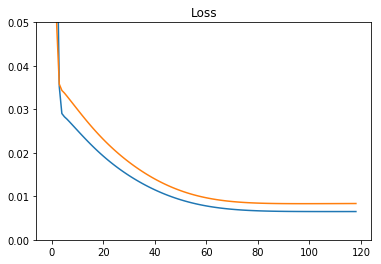

In [99]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylim(0, 0.05)
plt.title("Loss")
plt.show()

In [100]:
# 6. 모델 평가
trainScore = model3.evaluate(x_train, y_train, batch_size=1, verbose=0)
print('Train Score: ', trainScore)

testScore = model3.evaluate(x_test, y_test, batch_size=1, verbose=0)
print('Test Score: ', testScore)

Train Score:  0.006481989235965335
Test Score:  0.006728036487577402


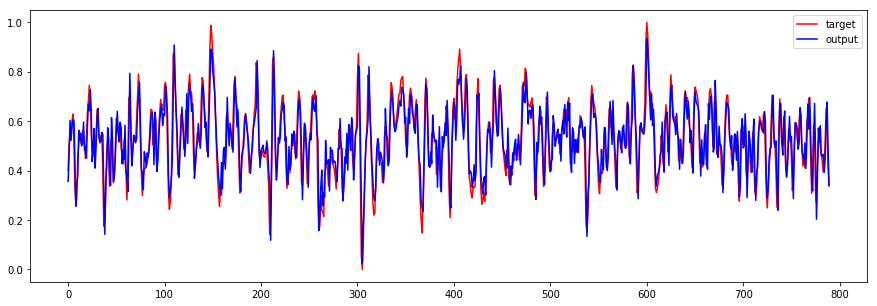

In [37]:
plt.figure(figsize = (15, 5))
plt.plot(y_train, 'r', label="target")
plt.plot(model3.predict(x_train), 'b', label="output")

plt.legend()
plt.show()

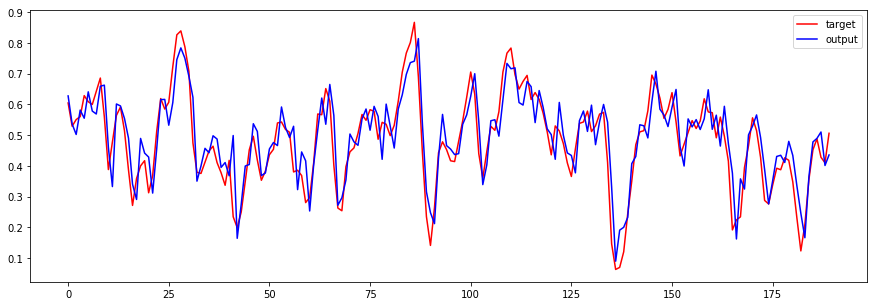

In [38]:
plt.figure(figsize = (15, 5))
plt.plot(y_test, 'r', label="target")
plt.plot(model3.predict(x_test), 'b', label="output")
plt.legend()
plt.show()

# 정규분포 데이터 추가

In [109]:
signal_data = arma_generate_sample(ar, ma, 10000)   # arima 데이터 생성
signal_data = signal_data[8900: ]
normal_data = np.random.normal(size = 1100)
print(normal_data[0:10])

[-1.35179787 -1.03343317  0.03554976  1.60553126 -1.11455952 -0.02245413
 -1.14865023 -2.07928353  1.33746142  0.47960837]


In [0]:
# [0, 1, 2, 3] , window_size = 2      =>   [ [0, 1], [1, 2], [2, 3] ]
def create_dataset2(signal_data, normal_data, window_size=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-window_size):
        dataX.append(list(zip(signal_data[i:(i+window_size)], normal_data[i:(i+window_size)])))
        dataY.append(signal_data[i + window_size])
    return np.array(dataX), np.array(dataY)

In [0]:
# MinMaxScalar
maxValue = np.max(signal_data)
minValue = np.min(signal_data)
signal_data = (signal_data - minValue) / (maxValue - minValue)


In [0]:
# 데이터 분리
train = signal_data[0:800]
val = signal_data[800:900]
test = signal_data[900:]

In [0]:
window_size = 2# 데이터셋 생성
x_train, y_train = create_dataset2(train, normal_data, window_size)
x_val, y_val = create_dataset2(val, normal_data, window_size)
x_test, y_test = create_dataset2(test, normal_data, window_size)

In [0]:
history = CustomHistory() # 손실 이력 객체 생성
history.init()
def fit_lstm(x_train, y_train, batch_size, nb_epoch, neurons):
  import time
  from time import strftime
  start_time = time.time()
  
  
  
  model = Sequential()
  model.add(LSTM(neurons, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences = False))
  model.add(Dense(1))
  print(model.summary())
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(x_train, y_train, epochs=nb_epoch, batch_size=batch_size, verbose=1, shuffle=False, callbacks=[history, es], validation_data = (x_val, y_val))
  print('\n걸린 시간(second) : ', time.time() - start_time)
  return model

In [115]:
# 5. 모델 학습시키기
num_epochs = 200

model4 = fit_lstm(x_train, y_train, 16, num_epochs, 8)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 8)                 352       
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 9         
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________
None
Train on 798 samples, validate on 98 samples
Epoch 1/200
798/798 [==============================] - 3s 4ms/step - loss: 0.1490 - val_loss: 0.1038
Epoch 2/200
798/798 [==============================] - 0s 245us/step - loss: 0.0517 - val_loss: 0.0336
Epoch 3/200
798/798 [==============================] - 0s 246us/step - loss: 0.0198 - val_loss: 0.0221
Epoch 4/200
798/798 [==============================] - 0s 246us/step - loss: 0.0175 - val_loss: 0.0216
Epoch 5/200
798/798 [==============================] - 0s

In [116]:
# 6. 모델 평가
trainScore = model4.evaluate(x_train, y_train, batch_size=1, verbose=0)
print('Train Score: ', trainScore)

testScore = model4.evaluate(x_test, y_test, batch_size=1, verbose=0)
print('Test Score: ', testScore)

Train Score:  0.006391027701323557
Test Score:  0.005196566284670647


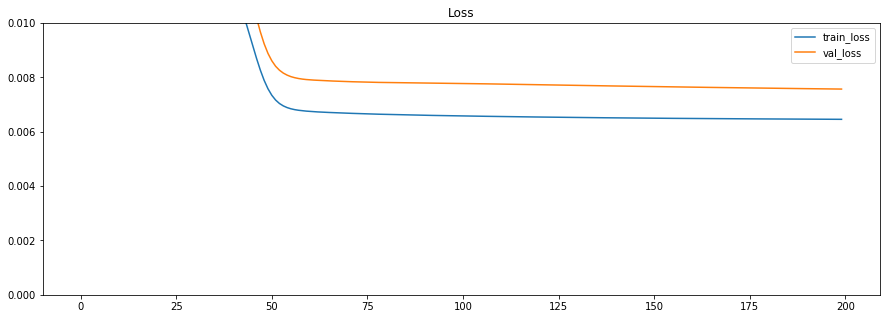

In [117]:
plt.figure(figsize=(15, 5))
plt.plot(history.train_loss,label = 'train_loss')
plt.plot(history.val_loss, label = 'val_loss')
plt.ylim(0, 0.01)
plt.legend()
plt.title("Loss")

plt.show()

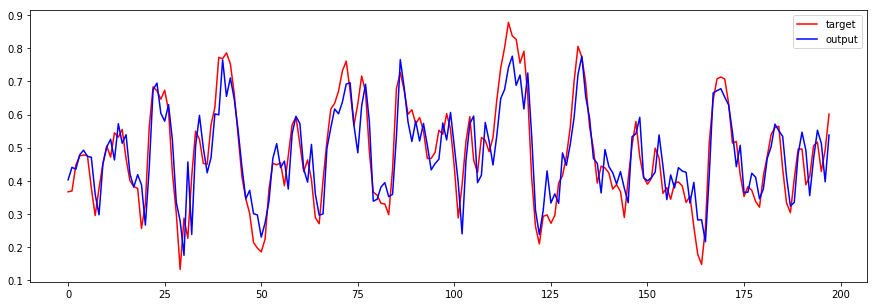

In [119]:
plt.figure(figsize = (15, 5))
plt.plot(y_test, 'r', label="target")
plt.plot(model4.predict(x_test), 'b', label="output")
plt.legend()
plt.show()